# SpaceNet 7 Data for Model Training



In [1]:
# Dataset location (edit as needed)
root_dir = '/local_data/sn7/aws_download/'

In [3]:
import multiprocessing
import pandas as pd
import numpy as np
import skimage
import gdal
import sys
import os

import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
mpl.rcParams['figure.dpi'] = 300

import solaris as sol
from solaris.raster.image import create_multiband_geotiff
from solaris.utils.core import _check_gdf_load

# import from data_prep_funcs
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sn7_baseline_prep_funcs import map_wrapper, make_geojsons_and_masks

ModuleNotFoundError: ignored

In [ ]:
# Create Training Masks
# Multi-thread to increase speed
aois = sorted([f for f in os.listdir(os.path.join(root_dir, 'train'))
               if os.path.isdir(os.path.join(root_dir, 'train', f))])
n_threads = 10
params = [] 
make_fbc = False

input_args = []
for i, aoi in enumerate(aois):
    print(i, "aoi:", aoi)
    im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked/')
    json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')
    out_dir_mask = os.path.join(root_dir, 'train', aoi, 'masks/')
    out_dir_mask_fbc = os.path.join(root_dir, 'train', aoi, 'masks_fbc/')
    os.makedirs(out_dir_mask, exist_ok=True)
    if make_fbc:
        os.makedirs(out_dir_mask_fbc, exist_ok=True)

    json_files = sorted([f
                for f in os.listdir(os.path.join(json_dir))
                if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])
    for j, f in enumerate(json_files):
        # print(i, j, f)
        name_root = f.split('.')[0]
        json_path = os.path.join(json_dir, f)
        image_path = os.path.join(im_dir, name_root + '.tif').replace('labels', 'images').replace('_Buildings', '')
        output_path_mask = os.path.join(out_dir_mask, name_root + '.tif')
        if make_fbc:
            output_path_mask_fbc = os.path.join(out_dir_mask_fbc, name_root + '.tif')
        else:
            output_path_mask_fbc = None
            
        if (os.path.exists(output_path_mask)):
             continue
        else: 
            input_args.append([make_geojsons_and_masks, 
                               name_root, image_path, json_path,
                               output_path_mask, output_path_mask_fbc])

# execute 
print("len input_args", len(input_args))
print("Execute...\n")
with multiprocessing.Pool(n_threads) as pool:
    pool.map(map_wrapper, input_args)


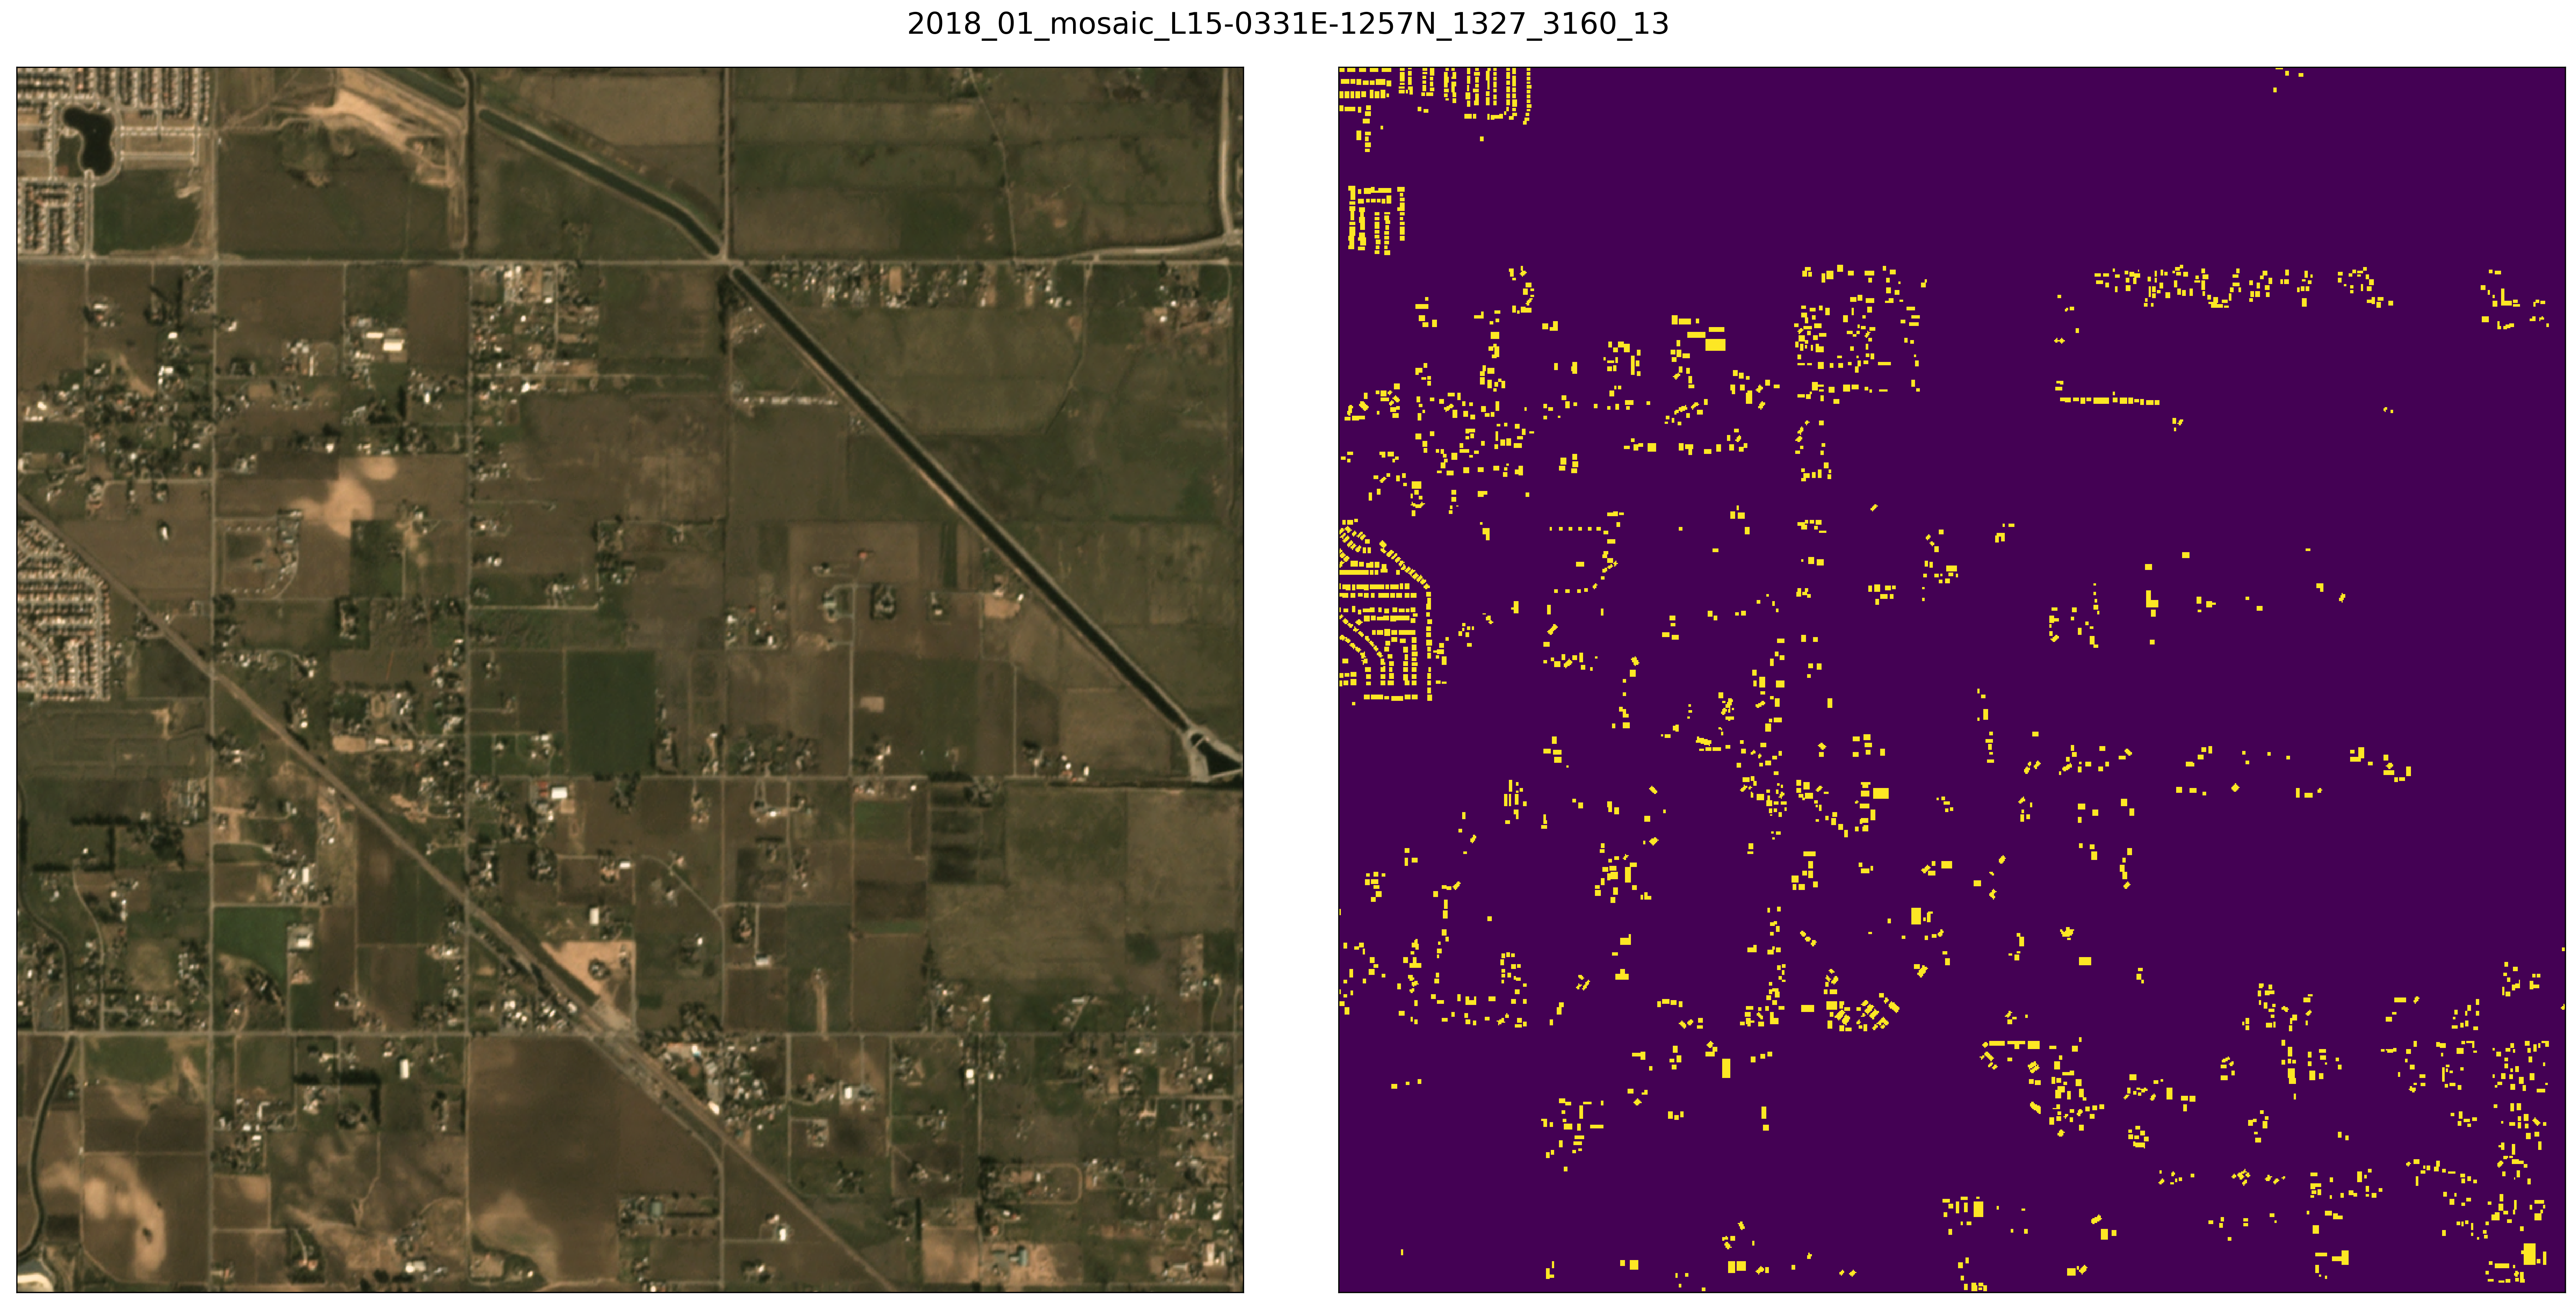

In [ ]:
# Inspect visually

aoi = 'L15-0331E-1257N_1327_3160_13'
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
mask_dir = os.path.join(root_dir, 'train', aoi, 'masks')

im_list = sorted([z for z in os.listdir(im_dir) if z.endswith('.tif')])
im_file = im_list[0]

im_path = os.path.join(im_dir, im_file)
mask_path = os.path.join(mask_dir, im_file.split('.')[0] + '_Buildings.tif')
im = skimage.io.imread(im_path)
mask = skimage.io.imread(mask_path)

figsize=(24, 12)
name = im_file.split('.')[0].split('global_monthly_')[-1]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(im)
ax0.set_xticks([])
ax0.set_yticks([])
# _ = ax0.set_title(name)
_ = ax1.imshow(mask)
ax1.set_xticks([])
ax1.set_yticks([])
# _ = ax1.set_title(name)
_ = fig.suptitle(name)
plt.tight_layout()

name_root: global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings


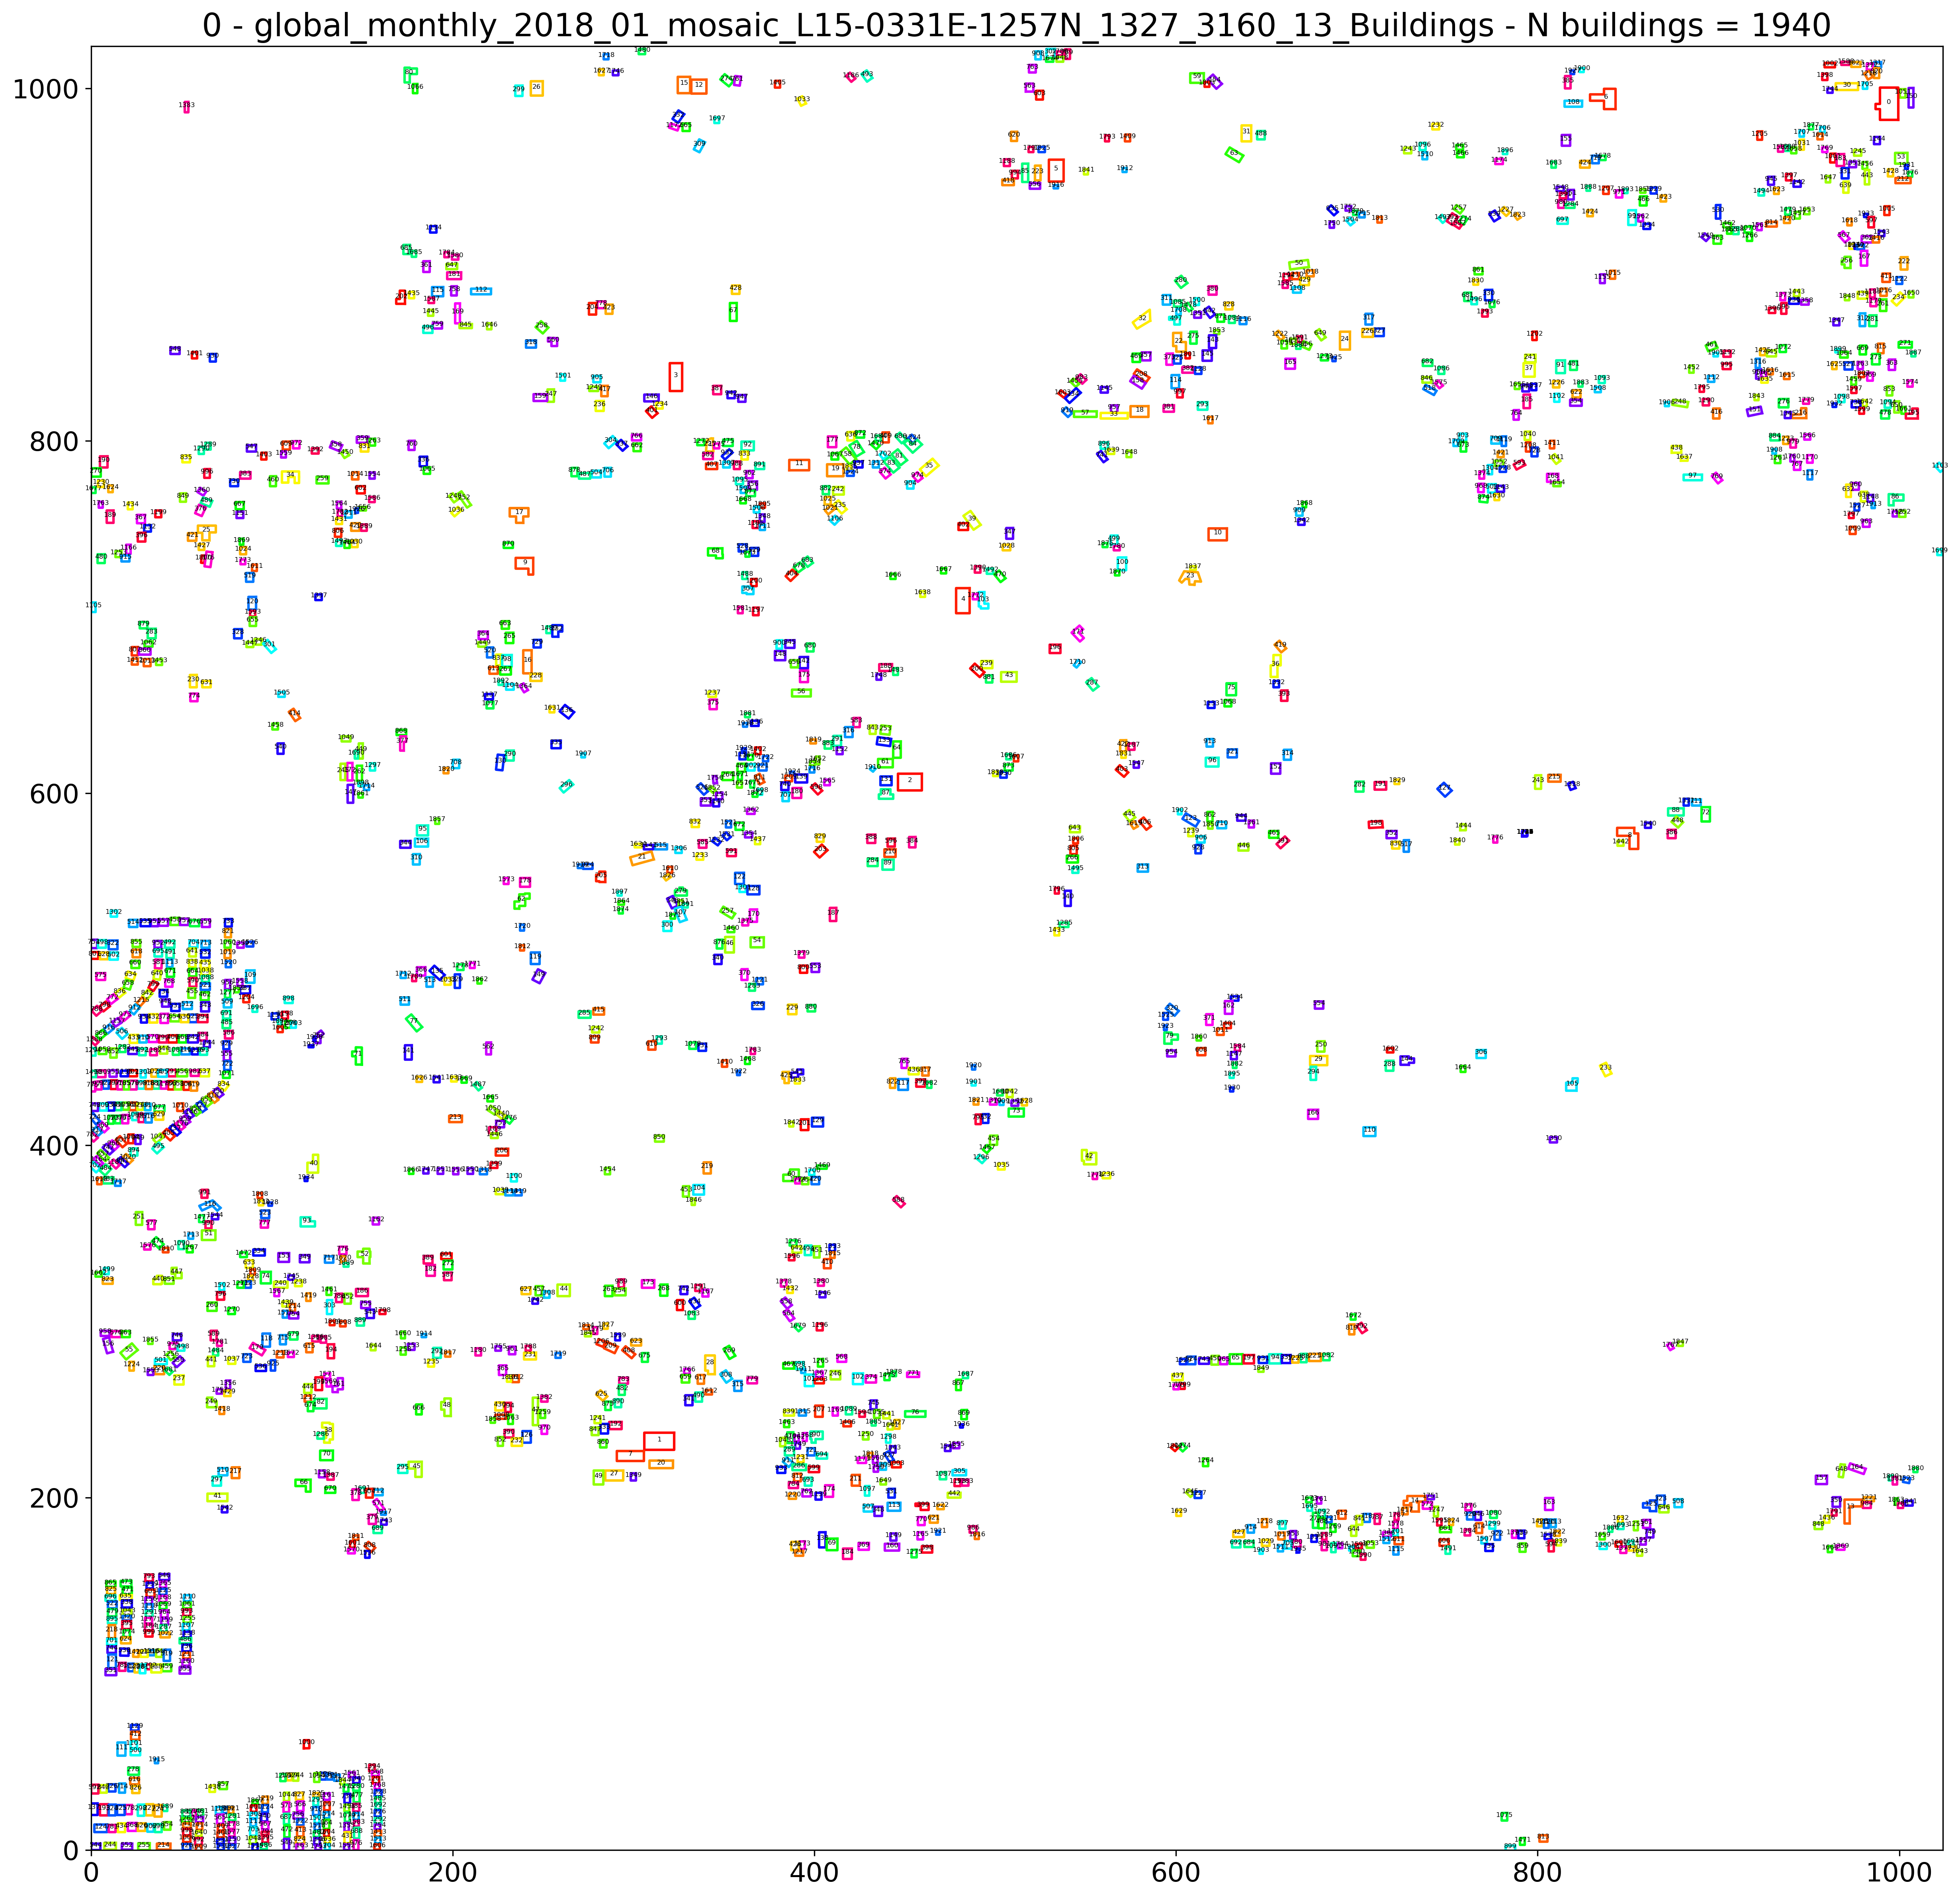

name_root: global_monthly_2020_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings


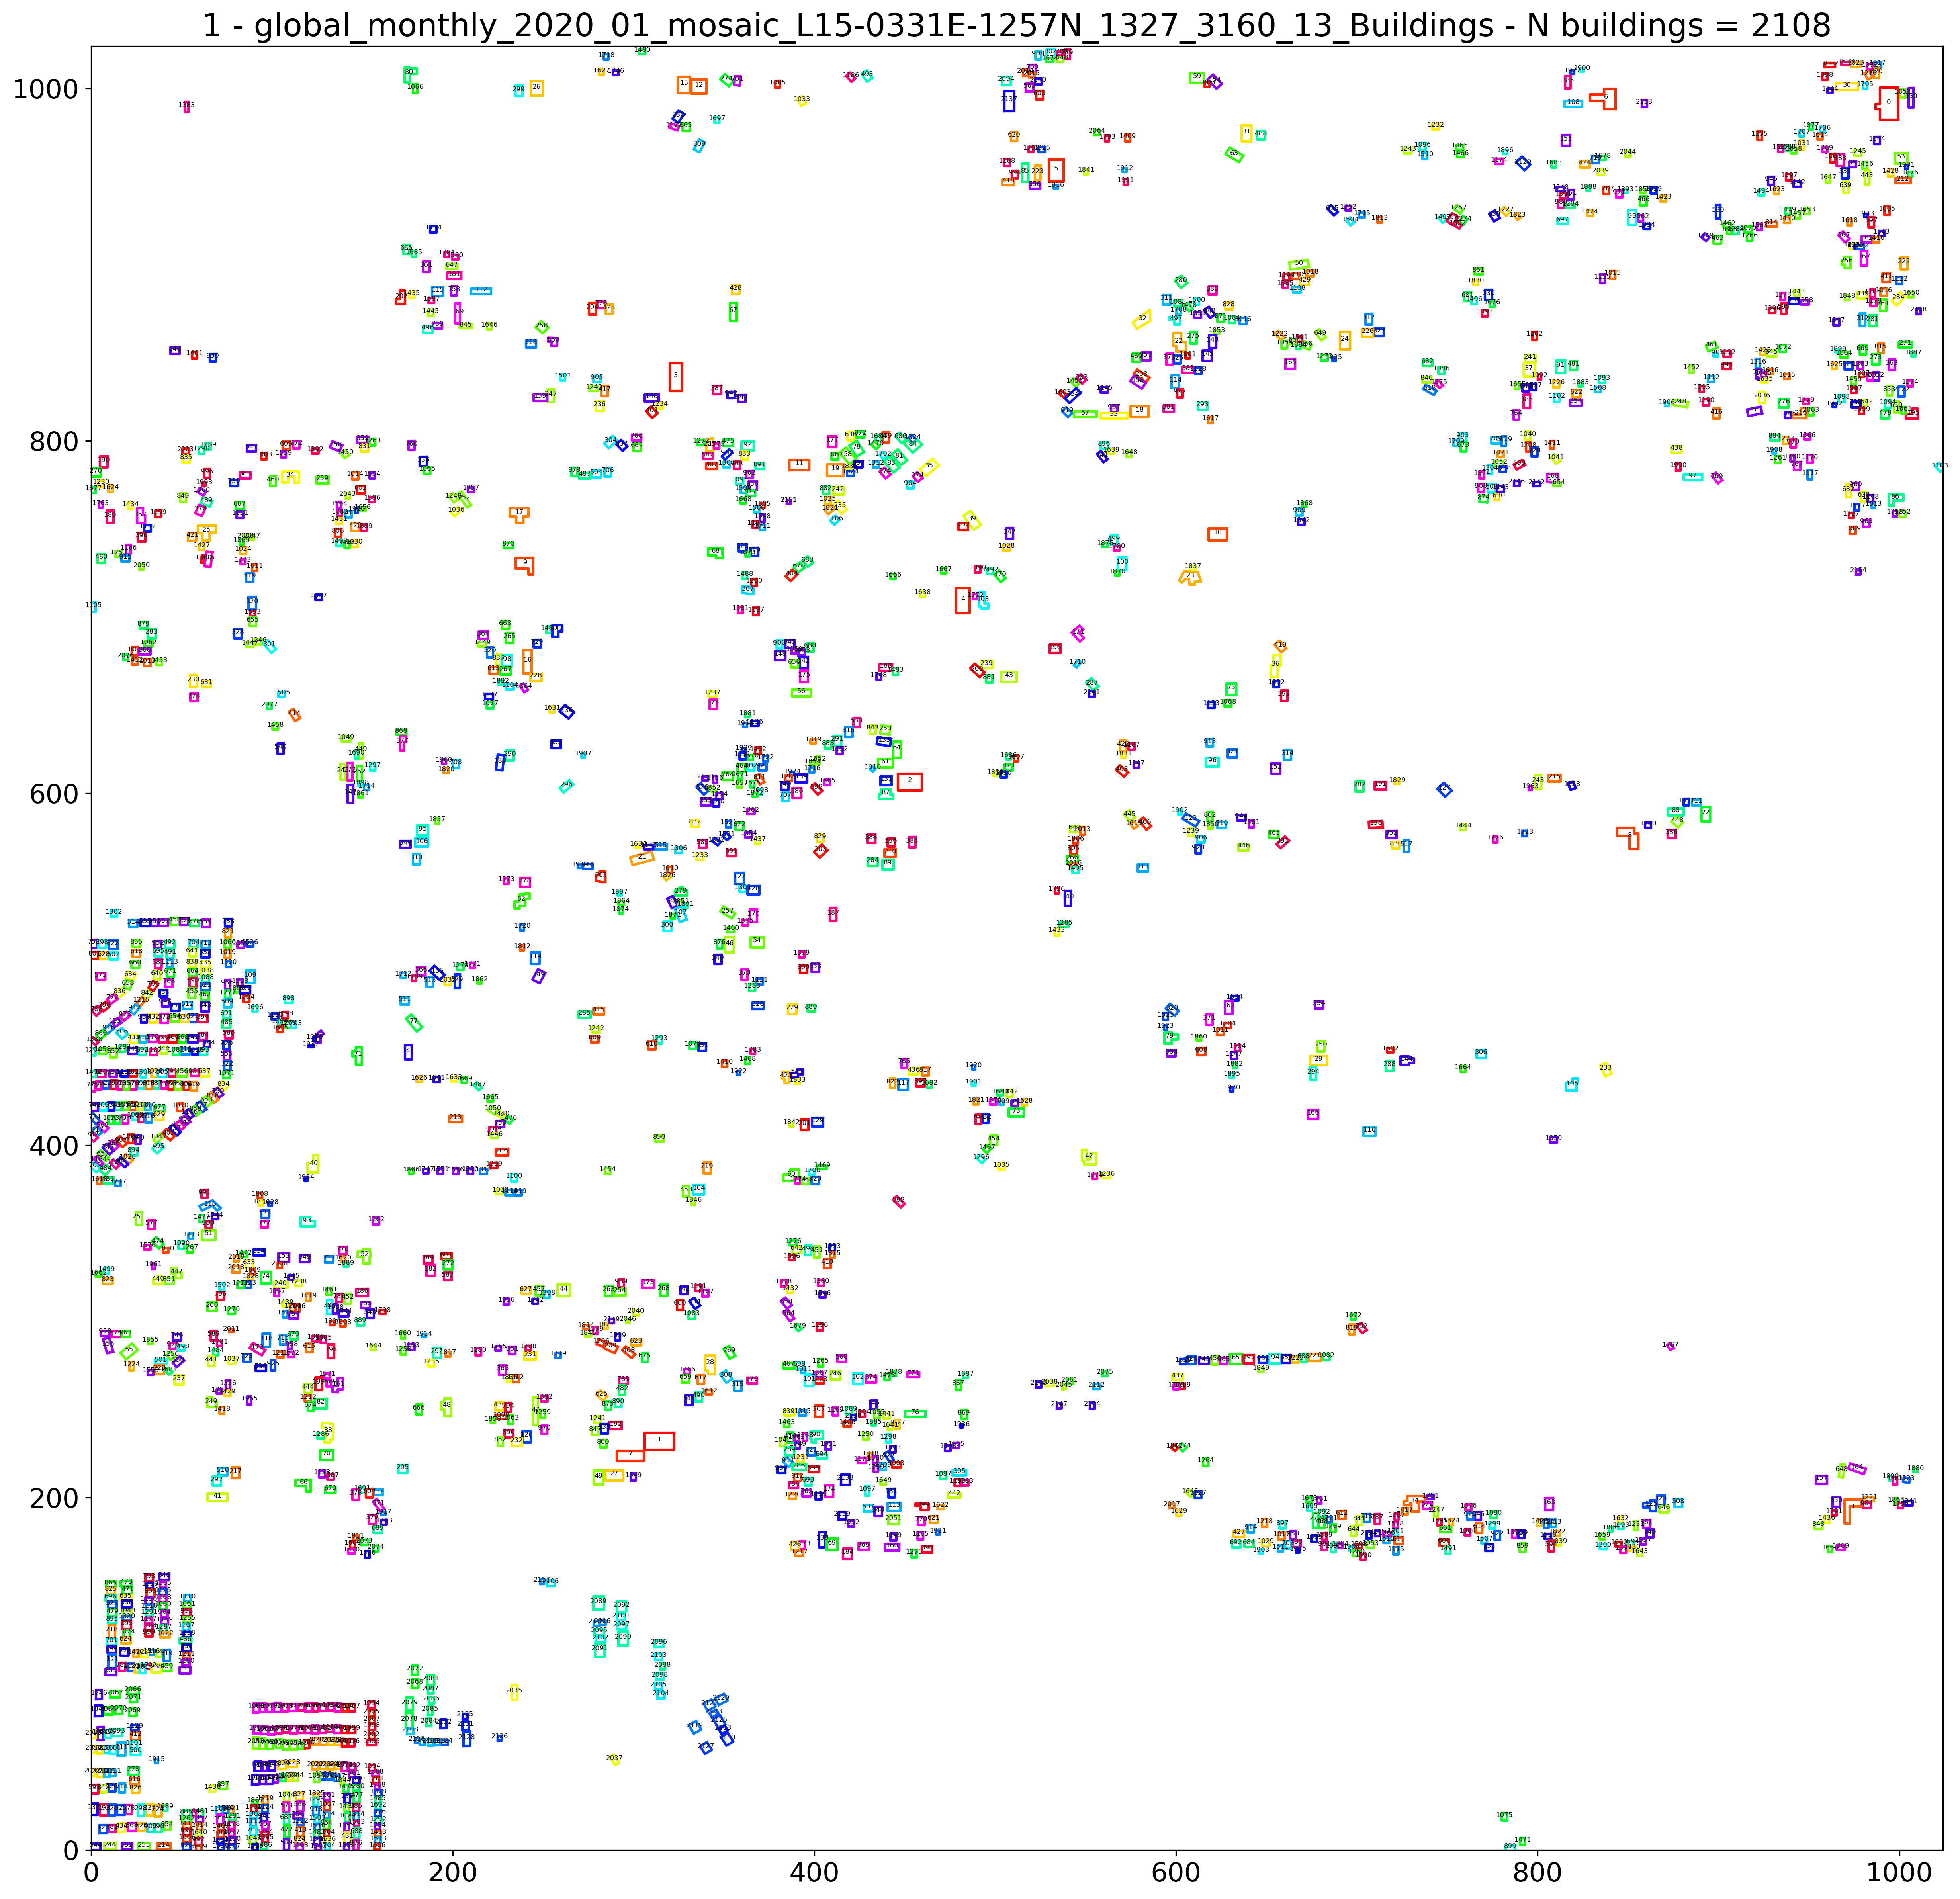

In [ ]:
# make identifier plots

aoi = 'L15-0331E-1257N_1327_3160_13'
im_dir = os.path.join(root_dir, 'train', aoi, 'images_masked')
json_dir = os.path.join(root_dir, 'train', aoi, 'labels_match/')

# colors
vmax = 200
cmap = plt.get_cmap('hsv')  # 'jet'
cNorm  = colors.Normalize(vmin=0, vmax=vmax)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
plot_only_first_and_last = True
label_font_size = 4
im_pix_size_x, im_pix_size_y = 1024, 1024
figsize=(20,20)

json_files = sorted([f
            for f in os.listdir(json_dir)
            if f.endswith('Buildings.geojson') and os.path.exists(os.path.join(json_dir, f))])
if plot_only_first_and_last:
    json_files = [json_files[0], json_files[-1]]

# convert json
for j, f in enumerate(json_files):
    # print(i, j, f)
    name_root = f.split('.')[0]
    json_path = os.path.join(json_dir, f)
    image_path = os.path.join(im_dir, name_root + '.tif').replace('_Buildings', '')
    print("name_root:", name_root)
    # print("json_path", json_path)
    # output_path = os.path.join(out_dir, f)
    # if os.path.exists(output_path):
    #    print("  path exists, skipping:", name_root)
    #    continue
    gdf_pix = sol.vector.polygon.geojson_to_px_gdf(json_path, image_path, geom_col='geometry', precision=None,
                  output_path=None, override_crs=False)
    fig, ax = plt.subplots(figsize=figsize)
    for _, row in gdf_pix.iterrows():
        geom = row['geometry']
        poly_id = row['Id']
        x, y = geom.exterior.xy
        cx, cy = np.array(geom.centroid.xy).astype(float)
        #print("centroid:", centroid)
        color_int = int(poly_id) % vmax
        colorVal = scalarMap.to_rgba(color_int)
        ax.plot(x, y, c=colorVal)
        # poly id
        ax.annotate(str(poly_id), xy=(cx, cy), ha='center', size=label_font_size)
        #text_object = plt.annotate(label, xy=(x_values[i], y_values[i]), ha='center')
        #ax.text(cx, cy, str(poly_id))
    ax.set_xlim(0, im_pix_size_x)
    ax.set_ylim(0, im_pix_size_y)
    title = str(j) + " - " + name_root + " - N buildings = " + str(len(gdf_pix))
    ax.set_title(title)

    plt.show()

In [ ]:
# Make dataframe csvs for train/test

out_dir = os.path.join(root_dir, 'csvs/')
pops = ['train', 'test_public']
os.makedirs(out_dir, exist_ok=True)

for pop in pops: 
    d = os.path.join(root_dir, pop)
    outpath = os.path.join(out_dir, 'sn7_baseline_' + pop + '_df.csv')
    im_list, mask_list = [], []
    subdirs = sorted([f for f in os.listdir(d) if os.path.isdir(os.path.join(d, f))])
    for subdir in subdirs:
        
        if pop == 'train':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            mask_files = [os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif')
                      for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                      if f.endswith('.tif') and os.path.exists(os.path.join(d, subdir, 'masks', f.split('.')[0] + '_Buildings.tif'))]
            im_list.extend(im_files)
            mask_list.extend(mask_files)
    
        elif pop == 'test_public':
            im_files = [os.path.join(d, subdir, 'images_masked', f)
                    for f in sorted(os.listdir(os.path.join(d, subdir, 'images_masked')))
                    if f.endswith('.tif')]
            im_list.extend(im_files)

    # save to dataframes
    # print("im_list:", im_list)
    # print("mask_list:", mask_list)
    if pop == 'train':
        df = pd.DataFrame({'image': im_list, 'label': mask_list})
        display(df.head())
    elif pop == 'test_public':
        df = pd.DataFrame({'image': im_list})
    df.to_csv(outpath, index=False)
    print(pop, "len df:", len(df))
    print("output csv:", outpath)